In [1]:
import pandas as pd
from os import path
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import TextVectorization
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from math import pi
from tensorflow.keras.layers import GRU
import numpy as np
import seaborn as sns
import os
from sklearn.model_selection import train_test_split

# Định nghĩa đường dẫn
DATA_DIR = r"c:\Users\Admin\Python\ABSA_Prompting\data"
RESULT_DIR = r"c:\Users\Admin\Python\ABSA_Prompting\results"
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(RESULT_DIR, exist_ok=True)

In [2]:
# CONFIG - Hotel Dataset
ViABSA_dir = path.join(DATA_DIR, 'ViABSA_Hotel')

train_file = path.join(ViABSA_dir, 'data_train.csv')

# Load train data to check structure
train_df = pd.read_csv(train_file)

print("Hotel dataset shape:", train_df.shape)
print("Columns:", train_df.columns.tolist())
train_df.head()

Hotel dataset shape: (3000, 35)
Columns: ['Review', 'FACILITIES#CLEANLINESS', 'FACILITIES#COMFORT', 'FACILITIES#DESIGN&FEATURES', 'FACILITIES#GENERAL', 'FACILITIES#MISCELLANEOUS', 'FACILITIES#PRICES', 'FACILITIES#QUALITY', 'FOOD&DRINKS#MISCELLANEOUS', 'FOOD&DRINKS#PRICES', 'FOOD&DRINKS#QUALITY', 'FOOD&DRINKS#STYLE&OPTIONS', 'HOTEL#CLEANLINESS', 'HOTEL#COMFORT', 'HOTEL#DESIGN&FEATURES', 'HOTEL#GENERAL', 'HOTEL#MISCELLANEOUS', 'HOTEL#PRICES', 'HOTEL#QUALITY', 'LOCATION#GENERAL', 'ROOMS#CLEANLINESS', 'ROOMS#COMFORT', 'ROOMS#DESIGN&FEATURES', 'ROOMS#GENERAL', 'ROOMS#MISCELLANEOUS', 'ROOMS#PRICES', 'ROOMS#QUALITY', 'ROOM_AMENITIES#CLEANLINESS', 'ROOM_AMENITIES#COMFORT', 'ROOM_AMENITIES#DESIGN&FEATURES', 'ROOM_AMENITIES#GENERAL', 'ROOM_AMENITIES#MISCELLANEOUS', 'ROOM_AMENITIES#PRICES', 'ROOM_AMENITIES#QUALITY', 'SERVICE#GENERAL']


,Review,FACILITIES#CLEANLINESS,FACILITIES#COMFORT,FACILITIES#DESIGN&FEATURES,FACILITIES#GENERAL,FACILITIES#MISCELLANEOUS,FACILITIES#PRICES,FACILITIES#QUALITY,FOOD&DRINKS#MISCELLANEOUS,FOOD&DRINKS#PRICES,...,ROOMS#PRICES,ROOMS#QUALITY,ROOM_AMENITIES#CLEANLINESS,ROOM_AMENITIES#COMFORT,ROOM_AMENITIES#DESIGN&FEATURES,ROOM_AMENITIES#GENERAL,ROOM_AMENITIES#MISCELLANEOUS,ROOM_AMENITIES#PRICES,ROOM_AMENITIES#QUALITY,SERVICE#GENERAL
0,Rộng rãi KS mới nhưng rất vắng. Các dịch vụ ch...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Địa điểm thuận tiện, trong vòng bán kính 1,5km...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Phục vụ, view đẹp, vị trí",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,"thuận tiện , sạch sẽ , vui vẻ hài lòng",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,Vị trí đẹp; Có quán bar view đẹp; Nhân viên th...,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [3]:
# PREPROCESSING - Hotel Dataset with Aspect Filtering
# Load separate train and test files
test_file = path.join(ViABSA_dir, 'data_test.csv')
test_df = pd.read_csv(test_file)

# Get aspect columns (exclude Review column)
aspect_columns = [col for col in train_df.columns if col != 'Review']
print(f"Found {len(aspect_columns)} aspects")

# Filter aspects with sufficient data (at least 10 samples where aspect != 0)
valid_aspects = []
for aspect in aspect_columns:
    aspect_count = (train_df[aspect] != 0).sum()
    if aspect_count >= 10:
        valid_aspects.append(aspect)
        print(f"{aspect}: {aspect_count} samples")
    else:
        print(f"Filtered out {aspect}: only {aspect_count} samples")

print(f"\nUsing {len(valid_aspects)} valid aspects out of {len(aspect_columns)} total aspects")

print(f"Train set: {train_df.shape}")
print(f"Test set: {test_df.shape}")

# Display sample
train_df.head()

Found 34 aspects
FACILITIES#CLEANLINESS: 172 samples
FACILITIES#COMFORT: 132 samples
FACILITIES#DESIGN&FEATURES: 525 samples
FACILITIES#GENERAL: 219 samples
FACILITIES#MISCELLANEOUS: 33 samples
FACILITIES#PRICES: 53 samples
FACILITIES#QUALITY: 208 samples
FOOD&DRINKS#MISCELLANEOUS: 13 samples
FOOD&DRINKS#PRICES: 118 samples
FOOD&DRINKS#QUALITY: 672 samples
FOOD&DRINKS#STYLE&OPTIONS: 569 samples
HOTEL#CLEANLINESS: 348 samples
HOTEL#COMFORT: 1139 samples
HOTEL#DESIGN&FEATURES: 877 samples
HOTEL#GENERAL: 1282 samples
HOTEL#MISCELLANEOUS: 108 samples
HOTEL#PRICES: 496 samples
HOTEL#QUALITY: 246 samples
LOCATION#GENERAL: 1196 samples
ROOMS#CLEANLINESS: 658 samples
ROOMS#COMFORT: 434 samples
ROOMS#DESIGN&FEATURES: 916 samples
ROOMS#GENERAL: 256 samples
Filtered out ROOMS#MISCELLANEOUS: only 5 samples
ROOMS#PRICES: 196 samples
ROOMS#QUALITY: 164 samples
ROOM_AMENITIES#CLEANLINESS: 89 samples
ROOM_AMENITIES#COMFORT: 100 samples
ROOM_AMENITIES#DESIGN&FEATURES: 354 samples
ROOM_AMENITIES#GENERAL

,Review,FACILITIES#CLEANLINESS,FACILITIES#COMFORT,FACILITIES#DESIGN&FEATURES,FACILITIES#GENERAL,FACILITIES#MISCELLANEOUS,FACILITIES#PRICES,FACILITIES#QUALITY,FOOD&DRINKS#MISCELLANEOUS,FOOD&DRINKS#PRICES,...,ROOMS#PRICES,ROOMS#QUALITY,ROOM_AMENITIES#CLEANLINESS,ROOM_AMENITIES#COMFORT,ROOM_AMENITIES#DESIGN&FEATURES,ROOM_AMENITIES#GENERAL,ROOM_AMENITIES#MISCELLANEOUS,ROOM_AMENITIES#PRICES,ROOM_AMENITIES#QUALITY,SERVICE#GENERAL
0,Rộng rãi KS mới nhưng rất vắng. Các dịch vụ ch...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Địa điểm thuận tiện, trong vòng bán kính 1,5km...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Phục vụ, view đẹp, vị trí",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,"thuận tiện , sạch sẽ , vui vẻ hài lòng",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,Vị trí đẹp; Có quán bar view đẹp; Nhân viên th...,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [4]:
# SET-UP DATA for BiLSTM
# Hotel dataset uses numerical sentiment: 0=none, 1=positive, 2=neutral, 3=negative

for aspect in valid_aspects:
    train_df[aspect + "_label"] = (train_df[aspect] != 0).astype(int)
    test_df[aspect + "_label"] = (test_df[aspect] != 0).astype(int)

aspect_labels = [aspect + "_label" for aspect in valid_aspects]

X_train = train_df['Review']
y_train_aspect = train_df[aspect_labels]
X_test = test_df['Review']
y_test_aspect = test_df[aspect_labels]

print("X_train shape:", X_train.shape)
print("y_train_aspect shape:", y_train_aspect.shape)
print("X_test shape:", X_test.shape) 
print("y_test_aspect shape:", y_test_aspect.shape)

print("\nAspect distribution in training set (top 10):")
aspect_counts = []
for aspect in valid_aspects:
    count = (train_df[aspect] != 0).sum()
    aspect_counts.append((aspect, count, count/len(train_df)*100))

aspect_counts.sort(key=lambda x: x[1], reverse=True)
for aspect, count, pct in aspect_counts[:10]:
    print(f"{aspect}: {count} samples ({pct:.1f}%)")

y_train_aspect.head()

X_train shape: (3000,)
y_train_aspect shape: (3000, 31)
X_test shape: (600,)
y_test_aspect shape: (600, 31)

Aspect distribution in training set (top 10):
SERVICE#GENERAL: 1912 samples (63.7%)
HOTEL#GENERAL: 1282 samples (42.7%)
LOCATION#GENERAL: 1196 samples (39.9%)
HOTEL#COMFORT: 1139 samples (38.0%)
ROOMS#DESIGN&FEATURES: 916 samples (30.5%)
HOTEL#DESIGN&FEATURES: 877 samples (29.2%)
FOOD&DRINKS#QUALITY: 672 samples (22.4%)
ROOMS#CLEANLINESS: 658 samples (21.9%)
FOOD&DRINKS#STYLE&OPTIONS: 569 samples (19.0%)
FACILITIES#DESIGN&FEATURES: 525 samples (17.5%)


,FACILITIES#CLEANLINESS_label,FACILITIES#COMFORT_label,FACILITIES#DESIGN&FEATURES_label,FACILITIES#GENERAL_label,FACILITIES#MISCELLANEOUS_label,FACILITIES#PRICES_label,FACILITIES#QUALITY_label,FOOD&DRINKS#MISCELLANEOUS_label,FOOD&DRINKS#PRICES_label,FOOD&DRINKS#QUALITY_label,...,ROOMS#DESIGN&FEATURES_label,ROOMS#GENERAL_label,ROOMS#PRICES_label,ROOMS#QUALITY_label,ROOM_AMENITIES#CLEANLINESS_label,ROOM_AMENITIES#COMFORT_label,ROOM_AMENITIES#DESIGN&FEATURES_label,ROOM_AMENITIES#GENERAL_label,ROOM_AMENITIES#QUALITY_label,SERVICE#GENERAL_label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


# **BiLSTM for Hotel Aspect Detection**

In [5]:
# Text Vectorization
print("Setting up text vectorization...")
print("X_train dtype:", X_train.dtype)
print("y_train_aspect dtypes:", y_train_aspect.dtypes.unique())

vectorizer = TextVectorization()
vectorizer.adapt(X_train.astype(str))

X_train_BiLSTM = vectorizer(X_train.astype(str))
X_test_BiLSTM = vectorizer(X_test.astype(str))

print("X_train_BiLSTM shape:", X_train_BiLSTM.shape)
print("X_test_BiLSTM shape:", X_test_BiLSTM.shape)

'''
BiLSTM Model for Multi-label Aspect Detection
- Multi-label: Each sample can have multiple aspects simultaneously 
- Use sigmoid activation (not softmax) for independent probability per aspect
- Use binary_crossentropy loss for multi-label classification
'''

vocab_size = len(vectorizer.get_vocabulary())
print(f"Vocabulary size: {vocab_size}")
print(f"Number of valid aspects: {len(aspect_labels)}")

# Build BiLSTM model
BiLSTM = Sequential([
    Embedding(input_dim=vocab_size, output_dim=100), 
    Bidirectional(LSTM(64)),
    Dense(len(aspect_labels), activation='sigmoid')  # sigmoid for multi-label
])

print("Model architecture:")
BiLSTM.summary()

Setting up text vectorization...
X_train dtype: object
y_train_aspect dtypes: [dtype('int64')]
X_train_BiLSTM shape: (3000, 1014)
X_test_BiLSTM shape: (600, 297)
Vocabulary size: 5914
Number of valid aspects: 31
Model architecture:
Model architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Compile and train model
BiLSTM.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

print("\nTraining BiLSTM model...")
history = BiLSTM.fit(X_train_BiLSTM, y_train_aspect, epochs=5, batch_size=32, validation_split=0.2)

print("\nMaking predictions...")
y_pred_aspect = BiLSTM.predict(X_test_BiLSTM)

y_pred_aspect_binary = (y_pred_aspect >= 0.5).astype(int)

f1_ad = f1_score(y_test_aspect, y_pred_aspect_binary, average='micro')
print(f"\nF1_ad (Aspect Detection): {f1_ad:.4f}")

print("\nTop 10 aspects by F1 score:")
aspect_f1_scores = []
for i, aspect in enumerate(valid_aspects):
    if aspect + "_label" in y_test_aspect.columns:
        f1 = f1_score(y_test_aspect[aspect + "_label"], y_pred_aspect_binary[:, i])
        aspect_f1_scores.append((aspect, f1))

aspect_f1_scores.sort(key=lambda x: x[1], reverse=True)
for aspect, f1 in aspect_f1_scores[:10]:
    print(f"{aspect}: {f1:.4f}")

print(f"\nOverall Statistics:")
print(f"Total predictions: {len(y_pred_aspect_binary)}")
print(f"True positives (any aspect): {(y_test_aspect.sum(axis=1) > 0).sum()}")
print(f"Predicted positives (any aspect): {(y_pred_aspect_binary.sum(axis=1) > 0).sum()}")


Training BiLSTM model...
Epoch 1/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 26s 317ms/step - accuracy: 0.0464 - loss: 0.4861 - val_accuracy: 0.0067 - val_loss: 0.3461
Epoch 2/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 26s 317ms/step - accuracy: 0.0464 - loss: 0.4861 - val_accuracy: 0.0067 - val_loss: 0.3461
Epoch 2/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 22s 299ms/step - accuracy: 0.0065 - loss: 0.3418 - val_accuracy: 0.0067 - val_loss: 0.3353
Epoch 3/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 22s 299ms/step - accuracy: 0.0065 - loss: 0.3418 - val_accuracy: 0.0067 - val_loss: 0.3353
Epoch 3/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 23s 302ms/step - accuracy: 0.0261 - loss: 0.3298 - val_accuracy: 0.0683 - val_loss: 0.3195
Epoch 4/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 23s 302ms/step - accuracy: 0.0261 - loss: 0.3298 - val_accuracy: 0.0683 - val_loss: 0.3195
Epoch 4/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 23s 301ms/step - accuracy: 0.0618 - loss: 0.3114 - val_accuracy: 0.0733 - val_loss: 0.3088
Epoch 5/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 23s 301ms/step - accuracy: 0.0618 - loss:

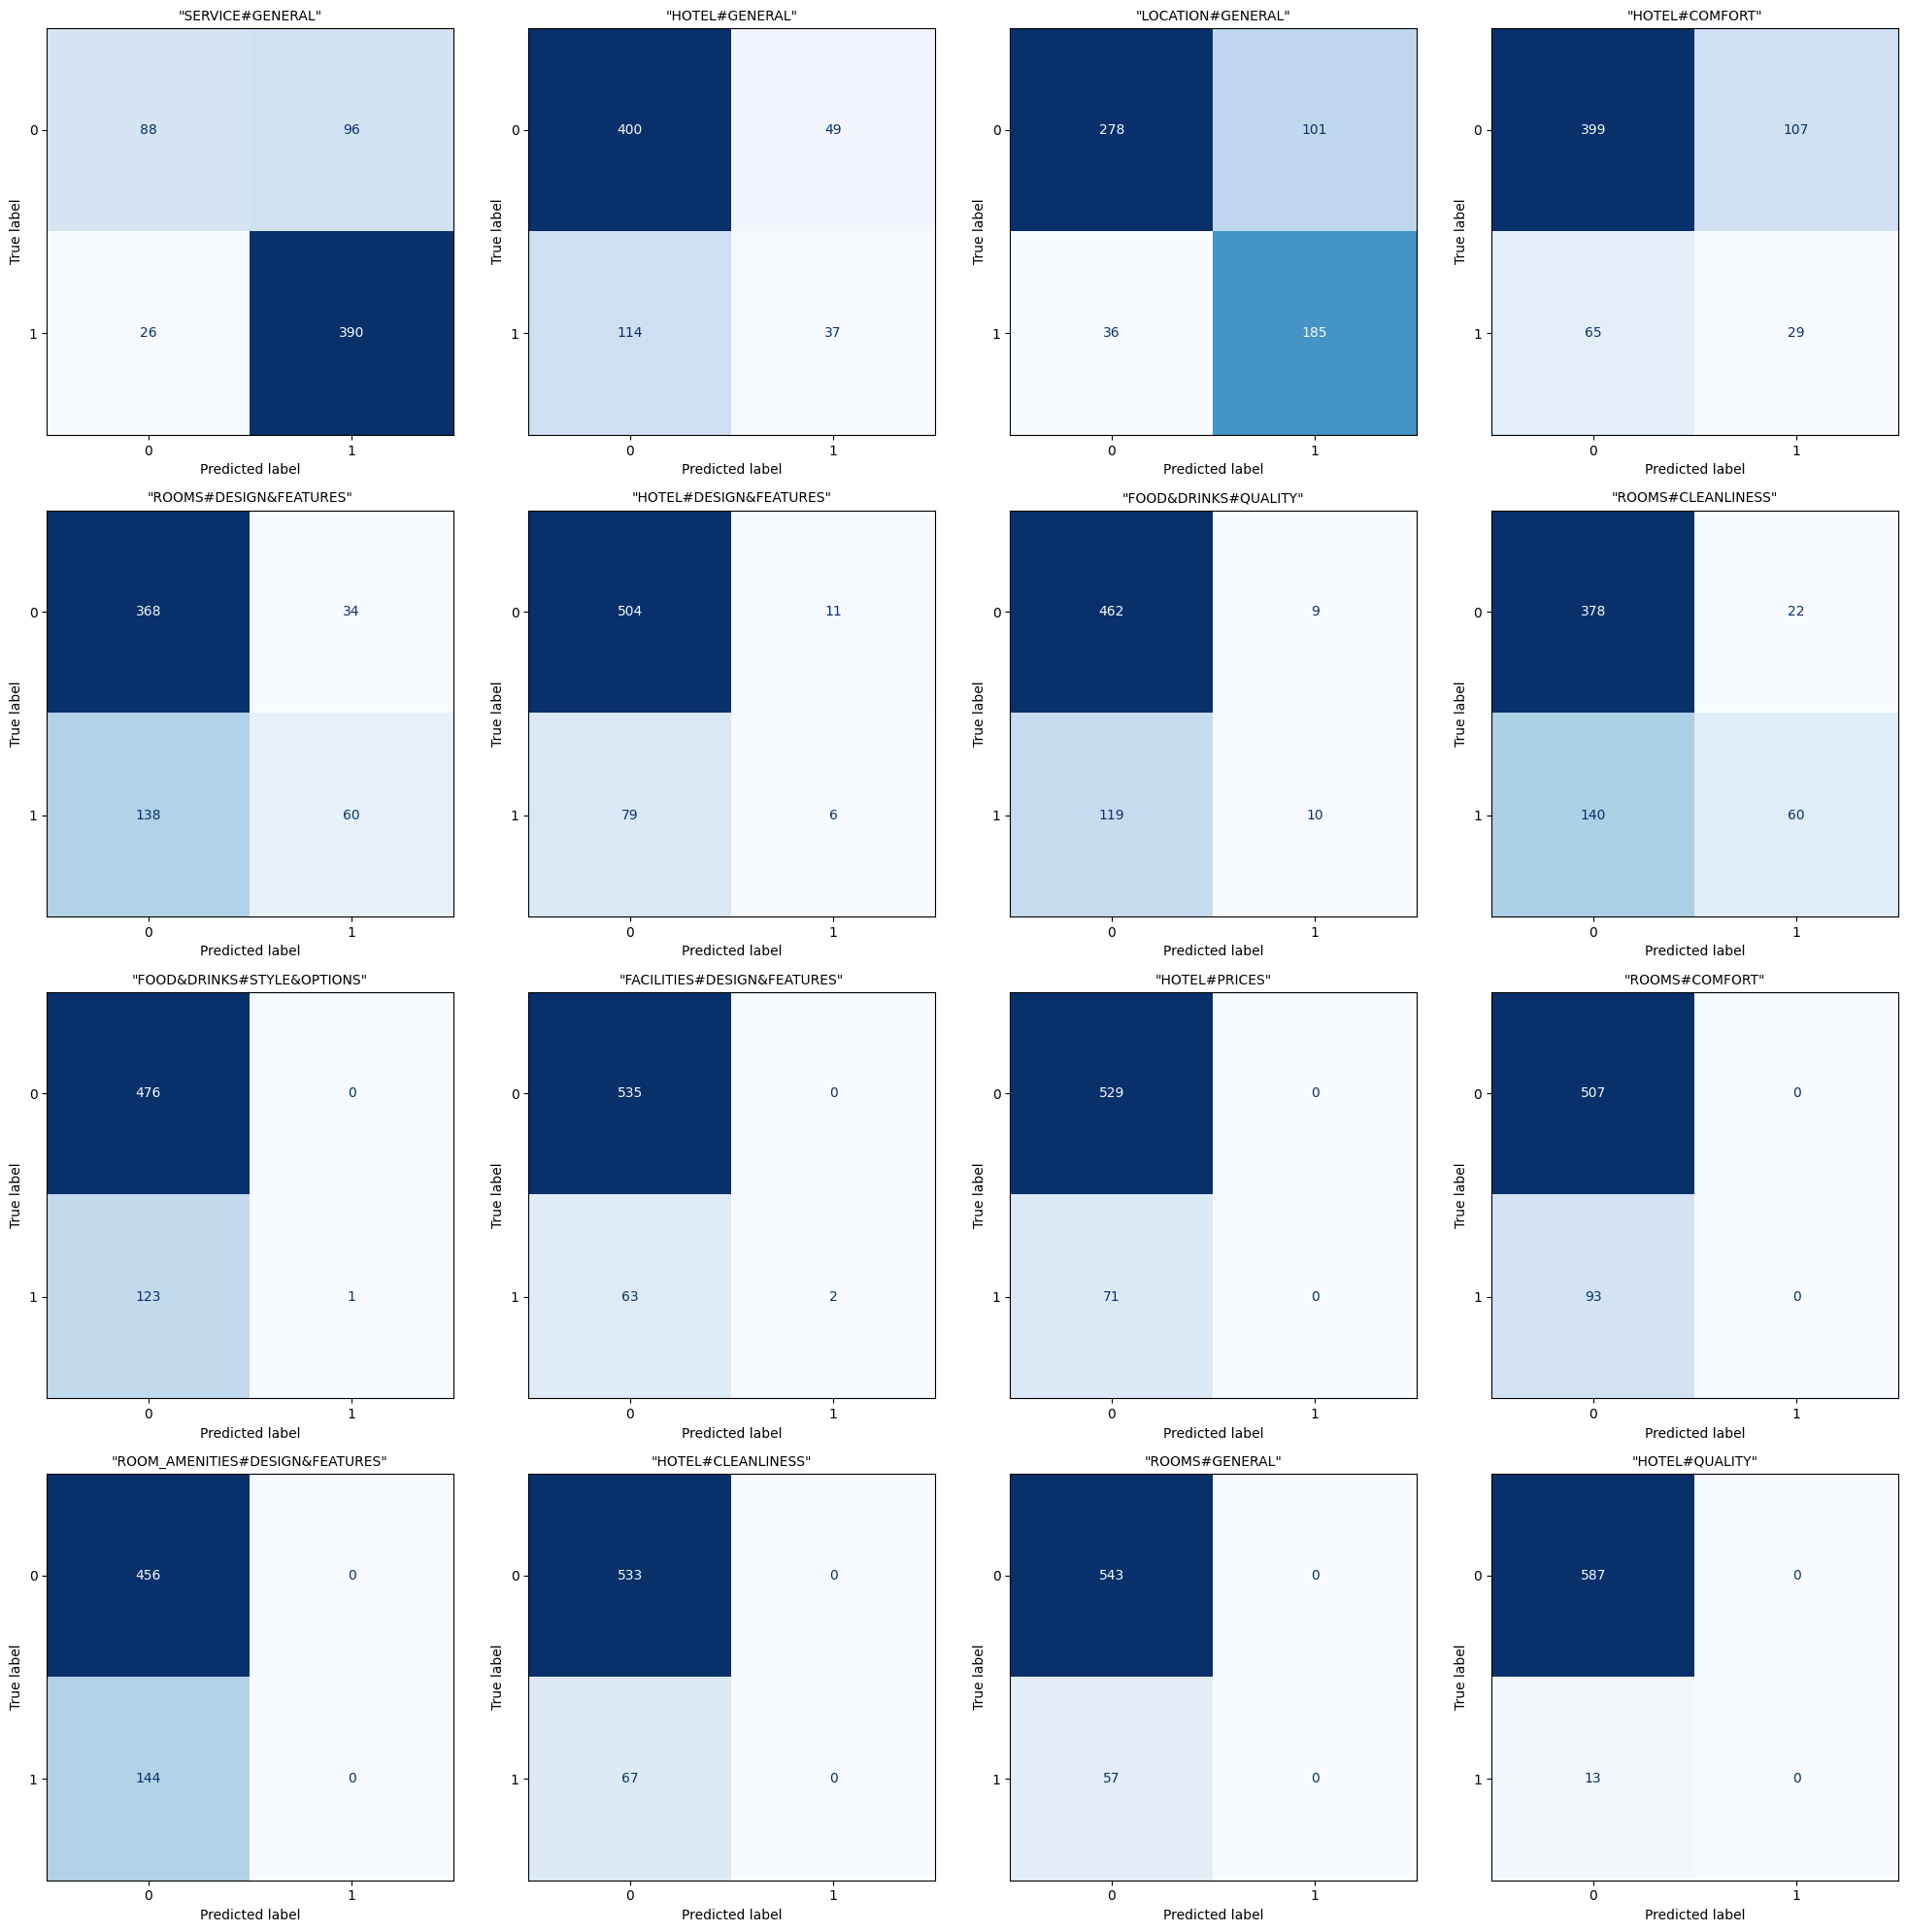

In [7]:
# Confusion Matrix Visualization for Top Aspects (showing top 16 by sample count)
top_aspects = [aspect for aspect, _, _ in aspect_counts[:16]]  # Top 16 aspects by count

cols = 4
rows = 4
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
axes = axes.flatten() 

for i, aspect in enumerate(top_aspects):
    if aspect in valid_aspects and aspect + "_label" in y_test_aspect.columns:
        aspect_idx = valid_aspects.index(aspect)
        y_true = y_test_aspect[aspect + "_label"]
        y_pred = y_pred_aspect_binary[:, aspect_idx]

        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
        disp.plot(ax=axes[i], cmap='Blues', colorbar=False)
        axes[i].set_title(f'"{aspect}"', fontsize=10)

# Remove unused subplots
for j in range(len(top_aspects), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [8]:
# SENTIMENT CLASSIFICATION
# 0=none(-1), 1=positive(2), 2=neutral(1), 3=negative(0)
sentiment_map = {0: -1, 1: 2, 2: 1, 3: 0} 

y_train_sentiment = {}
y_test_sentiment = {}

for aspect in valid_aspects:
    y_train_sentiment[aspect] = train_df[aspect].map(sentiment_map).fillna(-1).astype(int)
    y_test_sentiment[aspect] = test_df[aspect].map(sentiment_map).fillna(-1).astype(int)

# Check sentiment distribution for top aspects
print("Sentiment distribution for top 5 aspects:")
for aspect, _, _ in aspect_counts[:5]:
    if aspect in valid_aspects:
        print(f"\n{aspect}:")
        sentiment_counts = y_train_sentiment[aspect].value_counts().sort_index()
        for sent, count in sentiment_counts.items():
            label = {-1: 'none', 0: 'negative', 1: 'neutral', 2: 'positive'}[sent]
            print(f"  {label}: {count} ({count/len(y_train_sentiment[aspect])*100:.1f}%)")

Sentiment distribution for top 5 aspects:

SERVICE#GENERAL:
  none: 1088 (36.3%)
  negative: 96 (3.2%)
  neutral: 229 (7.6%)
  positive: 1587 (52.9%)

HOTEL#GENERAL:
  none: 1718 (57.3%)
  negative: 77 (2.6%)
  neutral: 99 (3.3%)
  positive: 1106 (36.9%)

LOCATION#GENERAL:
  none: 1804 (60.1%)
  negative: 51 (1.7%)
  neutral: 154 (5.1%)
  positive: 991 (33.0%)

HOTEL#COMFORT:
  none: 1861 (62.0%)
  negative: 7 (0.2%)
  neutral: 101 (3.4%)
  positive: 1031 (34.4%)

ROOMS#DESIGN&FEATURES:
  none: 2084 (69.5%)
  negative: 47 (1.6%)
  neutral: 279 (9.3%)
  positive: 590 (19.7%)


In [9]:
pipeline_sentiment = {}
sentiment_trained_aspects = []

print("Training sentiment models for aspects with sufficient data...")
for aspect in valid_aspects:
    mask_train = train_df[aspect + "_label"] == 1
    X_train_aspect = train_df[mask_train]
    y_train_aspect_sentiment = y_train_sentiment[aspect][mask_train]
    
    if len(X_train_aspect) > 20:  
        print(f"Training sentiment model for {aspect} ({len(X_train_aspect)} samples)")
        
        sentiment_BiLSTM = Sequential([
            vectorizer,
            Embedding(input_dim=vocab_size, output_dim=100),
            Bidirectional(LSTM(64)),
            Dense(3, activation='softmax') 
        ])
        
        sentiment_BiLSTM.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        sentiment_BiLSTM.fit(X_train_aspect['Review'].astype(str).values, y_train_aspect_sentiment.values, 
                            epochs=3, verbose=0)
        
        pipeline_sentiment[aspect] = sentiment_BiLSTM
        sentiment_trained_aspects.append(aspect)
    else:
        pipeline_sentiment[aspect] = None

print(f"\nTrained sentiment models for {len(sentiment_trained_aspects)} aspects:")

Training sentiment models for aspects with sufficient data...
Training sentiment model for FACILITIES#CLEANLINESS (172 samples)
Training sentiment model for FACILITIES#COMFORT (132 samples)
Training sentiment model for FACILITIES#COMFORT (132 samples)
Training sentiment model for FACILITIES#DESIGN&FEATURES (525 samples)
Training sentiment model for FACILITIES#DESIGN&FEATURES (525 samples)
Training sentiment model for FACILITIES#GENERAL (219 samples)
Training sentiment model for FACILITIES#GENERAL (219 samples)
Training sentiment model for FACILITIES#MISCELLANEOUS (33 samples)
Training sentiment model for FACILITIES#MISCELLANEOUS (33 samples)
Training sentiment model for FACILITIES#PRICES (53 samples)
Training sentiment model for FACILITIES#PRICES (53 samples)
Training sentiment model for FACILITIES#QUALITY (208 samples)
Training sentiment model for FACILITIES#QUALITY (208 samples)
Training sentiment model for FOOD&DRINKS#PRICES (118 samples)
Training sentiment model for FOOD&DRINKS#PRI

In [10]:
num_samples = len(X_test)
y_pred_sentiment = np.full((num_samples, len(valid_aspects)), -1)

print("Making sentiment predictions...")
for i, aspect in enumerate(valid_aspects):
    model = pipeline_sentiment[aspect]
    if model is not None:
        mask_pred = y_pred_aspect_binary[:, i] == 1 
        if np.any(mask_pred):
            X_test_aspect = X_test[mask_pred].astype(str).values
            
            y_pred_prob = model.predict(X_test_aspect, verbose=0)
            y_pred_label = np.argmax(y_pred_prob, axis=1)
            
            # Assign predictions
            y_pred_sentiment[mask_pred, i] = y_pred_label

f1_sc_list = []
print("\nSentiment Classification F1 Scores (top 10):")
sentiment_f1_scores = []

for i, aspect in enumerate(valid_aspects):
    mask = (y_pred_aspect_binary[:, i] == 1) & (y_test_sentiment[aspect] != -1)
    if np.sum(mask) > 5: 
        f1 = f1_score(
            y_test_sentiment[aspect][mask],
            y_pred_sentiment[mask, i],
            average='weighted'
        )
        f1_sc_list.append(f1)
        sentiment_f1_scores.append((aspect, f1, np.sum(mask)))

# Sort by F1 score and show top 10
sentiment_f1_scores.sort(key=lambda x: x[1], reverse=True)
for aspect, f1, sample_count in sentiment_f1_scores[:10]:
    print(f"F1_sc ({aspect}): {f1:.4f} ({sample_count} samples)")

if f1_sc_list:
    print(f"\nOverall F1_sc (weighted average): {np.mean(f1_sc_list):.4f}")
    print(f"Number of aspects with sentiment predictions: {len(f1_sc_list)}")
else:
    print("\nNo sentiment predictions could be evaluated")

Making sentiment predictions...

Sentiment Classification F1 Scores (top 10):
F1_sc (HOTEL#DESIGN&FEATURES): 1.0000 (6 samples)
F1_sc (HOTEL#GENERAL): 0.9596 (37 samples)
F1_sc (HOTEL#COMFORT): 0.8978 (29 samples)
F1_sc (SERVICE#GENERAL): 0.8455 (390 samples)
F1_sc (ROOMS#CLEANLINESS): 0.8442 (60 samples)
F1_sc (LOCATION#GENERAL): 0.8347 (185 samples)
F1_sc (ROOMS#DESIGN&FEATURES): 0.5574 (60 samples)
F1_sc (FOOD&DRINKS#QUALITY): 0.3333 (10 samples)

Overall F1_sc (weighted average): 0.7841
Number of aspects with sentiment predictions: 8

Sentiment Classification F1 Scores (top 10):
F1_sc (HOTEL#DESIGN&FEATURES): 1.0000 (6 samples)
F1_sc (HOTEL#GENERAL): 0.9596 (37 samples)
F1_sc (HOTEL#COMFORT): 0.8978 (29 samples)
F1_sc (SERVICE#GENERAL): 0.8455 (390 samples)
F1_sc (ROOMS#CLEANLINESS): 0.8442 (60 samples)
F1_sc (LOCATION#GENERAL): 0.8347 (185 samples)
F1_sc (ROOMS#DESIGN&FEATURES): 0.5574 (60 samples)
F1_sc (FOOD&DRINKS#QUALITY): 0.3333 (10 samples)

Overall F1_sc (weighted average):

# **BiGRU**

In [11]:
from tensorflow.keras.layers import GRU

X_train_BiGRU = vectorizer(X_train.astype(str))
X_test_BiGRU = vectorizer(X_test.astype(str))

BiGRU = Sequential([
    Embedding(input_dim=vocab_size, output_dim=100),
    Bidirectional(GRU(64)),
    Dense(len(aspect_labels), activation='sigmoid')
])

BiGRU.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
BiGRU.fit(X_train_BiGRU, y_train_aspect, epochs=5, batch_size=32, validation_split=0.2)

y_pred_aspect_gru = BiGRU.predict(X_test_BiGRU)
y_pred_aspect_gru_binary = (y_pred_aspect_gru >= 0.5).astype(int)

f1_ad_gru = f1_score(y_test_aspect, y_pred_aspect_gru_binary, average='micro')
print(f"BiGRU F1_ad: {f1_ad_gru:.4f}")

Epoch 1/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 251ms/step - accuracy: 0.0173 - loss: 0.5025 - val_accuracy: 0.0067 - val_loss: 0.3445
Epoch 2/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 251ms/step - accuracy: 0.0173 - loss: 0.5025 - val_accuracy: 0.0067 - val_loss: 0.3445
Epoch 2/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 239ms/step - accuracy: 0.0079 - loss: 0.3393 - val_accuracy: 0.0117 - val_loss: 0.3299
Epoch 3/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 239ms/step - accuracy: 0.0079 - loss: 0.3393 - val_accuracy: 0.0117 - val_loss: 0.3299
Epoch 3/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 248ms/step - accuracy: 0.0265 - loss: 0.3226 - val_accuracy: 0.1083 - val_loss: 0.3164
Epoch 4/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 248ms/step - accuracy: 0.0265 - loss: 0.3226 - val_accuracy: 0.1083 - val_loss: 0.3164
Epoch 4/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 245ms/step - accuracy: 0.1141 - loss: 0.3044 - val_accuracy: 0.1050 - val_loss: 0.3055
Epoch 5/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 245ms/step - accuracy: 0.1141 - loss: 0.3044 - val_accuracy: 0.

In [12]:
# BiGRU Sentiment Classification
pipeline_sentiment_gru = {}

for aspect in valid_aspects:
    mask_train = train_df[aspect + "_label"] == 1
    X_train_aspect = train_df[mask_train]
    y_train_aspect_sentiment = y_train_sentiment[aspect][mask_train]
    
    if len(X_train_aspect) > 20:
        sentiment_BiGRU = Sequential([
            vectorizer,
            Embedding(input_dim=vocab_size, output_dim=100),
            Bidirectional(GRU(64)),
            Dense(3, activation='softmax')
        ])
        
        sentiment_BiGRU.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        sentiment_BiGRU.fit(X_train_aspect['Review'].astype(str).values, y_train_aspect_sentiment.values, 
                           epochs=3, verbose=0)
        
        pipeline_sentiment_gru[aspect] = sentiment_BiGRU
    else:
        pipeline_sentiment_gru[aspect] = None

# BiGRU Sentiment Predictions
y_pred_sentiment_gru = np.full((num_samples, len(valid_aspects)), -1)

for i, aspect in enumerate(valid_aspects):
    model = pipeline_sentiment_gru[aspect]
    if model is not None:
        mask_pred = y_pred_aspect_gru_binary[:, i] == 1
        if np.any(mask_pred):
            X_test_aspect = X_test[mask_pred].astype(str).values
            y_pred_prob = model.predict(X_test_aspect, verbose=0)
            y_pred_label = np.argmax(y_pred_prob, axis=1)
            y_pred_sentiment_gru[mask_pred, i] = y_pred_label

f1_sc_list_gru = []
for i, aspect in enumerate(valid_aspects):
    mask = (y_pred_aspect_gru_binary[:, i] == 1) & (y_test_sentiment[aspect] != -1)
    if np.sum(mask) > 5:
        f1 = f1_score(y_test_sentiment[aspect][mask], y_pred_sentiment_gru[mask, i], average='weighted')
        f1_sc_list_gru.append(f1)

f1_sc_gru = np.mean(f1_sc_list_gru) if f1_sc_list_gru else 0
print(f"BiGRU F1_sc: {f1_sc_gru:.4f}")

BiGRU F1_sc: 0.7695


# **BiLSTM + Conv1D**

In [13]:
BiLSTM_Conv1D = Sequential([
    Embedding(input_dim=vocab_size, output_dim=100),
    Bidirectional(LSTM(64, return_sequences=True)),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(len(aspect_labels), activation='sigmoid')
])

BiLSTM_Conv1D.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
BiLSTM_Conv1D.fit(X_train_BiLSTM, y_train_aspect, epochs=5, batch_size=32, validation_split=0.2)

y_pred_aspect_conv = BiLSTM_Conv1D.predict(X_test_BiLSTM)
y_pred_aspect_conv_binary = (y_pred_aspect_conv >= 0.5).astype(int)

f1_ad_conv = f1_score(y_test_aspect, y_pred_aspect_conv_binary, average='micro')
print(f"BiLSTM+Conv1D F1_ad: {f1_ad_conv:.4f}")

Epoch 1/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 299ms/step - accuracy: 0.0064 - loss: 0.4482 - val_accuracy: 0.0067 - val_loss: 0.3491
Epoch 2/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 299ms/step - accuracy: 0.0064 - loss: 0.4482 - val_accuracy: 0.0067 - val_loss: 0.3491
Epoch 2/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 23s 309ms/step - accuracy: 0.0078 - loss: 0.3460 - val_accuracy: 0.0067 - val_loss: 0.3351
Epoch 3/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 23s 309ms/step - accuracy: 0.0078 - loss: 0.3460 - val_accuracy: 0.0067 - val_loss: 0.3351
Epoch 3/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 23s 306ms/step - accuracy: 0.0394 - loss: 0.3289 - val_accuracy: 0.0833 - val_loss: 0.3051
Epoch 4/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 23s 306ms/step - accuracy: 0.0394 - loss: 0.3289 - val_accuracy: 0.0833 - val_loss: 0.3051
Epoch 4/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 23s 309ms/step - accuracy: 0.0745 - loss: 0.2921 - val_accuracy: 0.1083 - val_loss: 0.2855
Epoch 5/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 23s 309ms/step - accuracy: 0.0745 - loss: 0.2921 - val_accuracy: 0.

In [14]:
# BiLSTM+Conv1D Sentiment Classification
pipeline_sentiment_conv = {}

for aspect in valid_aspects:
    mask_train = train_df[aspect + "_label"] == 1
    X_train_aspect = train_df[mask_train]
    y_train_aspect_sentiment = y_train_sentiment[aspect][mask_train]
    
    if len(X_train_aspect) > 20:
        sentiment_Conv = Sequential([
            vectorizer,
            Embedding(input_dim=vocab_size, output_dim=100),
            Bidirectional(LSTM(64, return_sequences=True)),
            Conv1D(filters=128, kernel_size=3, activation='relu'),
            GlobalMaxPooling1D(),
            Dense(3, activation='softmax')
        ])
        
        sentiment_Conv.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        sentiment_Conv.fit(X_train_aspect['Review'].astype(str).values, y_train_aspect_sentiment.values, 
                          epochs=3, verbose=0)
        
        pipeline_sentiment_conv[aspect] = sentiment_Conv
    else:
        pipeline_sentiment_conv[aspect] = None

# BiLSTM+Conv1D Sentiment Predictions
y_pred_sentiment_conv = np.full((num_samples, len(valid_aspects)), -1)

for i, aspect in enumerate(valid_aspects):
    model = pipeline_sentiment_conv[aspect]
    if model is not None:
        mask_pred = y_pred_aspect_conv_binary[:, i] == 1
        if np.any(mask_pred):
            X_test_aspect = X_test[mask_pred].astype(str).values
            y_pred_prob = model.predict(X_test_aspect, verbose=0)
            y_pred_label = np.argmax(y_pred_prob, axis=1)
            y_pred_sentiment_conv[mask_pred, i] = y_pred_label

f1_sc_list_conv = []
for i, aspect in enumerate(valid_aspects):
    mask = (y_pred_aspect_conv_binary[:, i] == 1) & (y_test_sentiment[aspect] != -1)
    if np.sum(mask) > 5:
        f1 = f1_score(y_test_sentiment[aspect][mask], y_pred_sentiment_conv[mask, i], average='weighted')
        f1_sc_list_conv.append(f1)

f1_sc_conv = np.mean(f1_sc_list_conv) if f1_sc_list_conv else 0
print(f"BiLSTM+Conv1D F1_sc: {f1_sc_conv:.4f}")

BiLSTM+Conv1D F1_sc: 0.8309


In [15]:
print("=== Hotel Dataset - Model Comparison ===")
print(f"BiLSTM F1_ad: {f1_ad:.4f}, F1_sc: {np.mean(f1_sc_list):.4f}")
print(f"BiGRU F1_ad: {f1_ad_gru:.4f}, F1_sc: {f1_sc_gru:.4f}")
print(f"BiLSTM+Conv1D F1_ad: {f1_ad_conv:.4f}, F1_sc: {f1_sc_conv:.4f}")
print(f"Valid aspects used: {len(valid_aspects)}")

=== Hotel Dataset - Model Comparison ===
BiLSTM F1_ad: 0.4122, F1_sc: 0.7841
BiGRU F1_ad: 0.4202, F1_sc: 0.7695
BiLSTM+Conv1D F1_ad: 0.5483, F1_sc: 0.8309
Valid aspects used: 31
